In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from utils import plot_images
from image_datasets import load_nist_data
from tqdm import tqdm

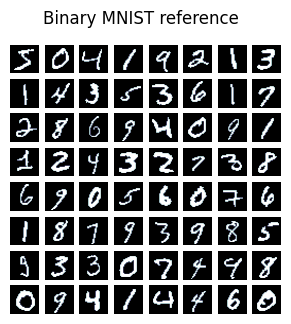

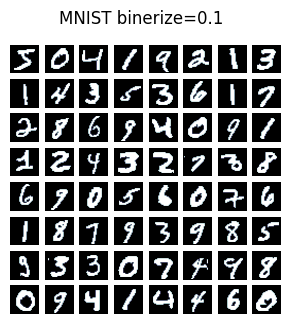

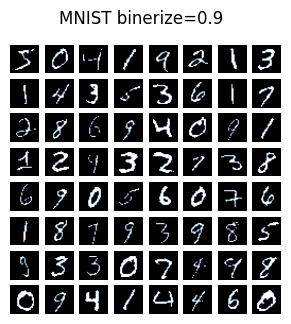

In [14]:
cmap='bone'


data = load_nist_data(name='BinaryMNIST')
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Binary MNIST reference", figsize=(3.5, 3.5), cmap=cmap)

#...Distorted datasets:

data = load_nist_data(name='MNIST', distortion='binerize', level=0.1)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "MNIST binerize=0.1", figsize=(3.5, 3.5), cmap=cmap)

data = load_nist_data(name='MNIST', distortion='binerize', level=0.9)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "MNIST binerize=0.9", figsize=(3.5, 3.5), cmap=cmap)


#data = load_nist_data(name='MNIST', distortion='pixelize', level=0.5,unet_resize=True)
#dataloader_c = DataLoader(data, batch_size=64, shuffle=False)
#images, _ = next(iter(dataloader_a))
#plot_images(images, "MNIST pixelated", figsize=(3.5, 3.5), cmap=cmap)

In [3]:
import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=64)

In [5]:
import torch
from torchvision.transforms import functional as Fv


def preprocess_image(image):
    image = image.permute(0, 3, 1, 2) / 255.0
    return Fv.center_crop(image, (256, 256))
    
def prepare_images_for_fid(dataloader,number_of_images=1000,device=torch.device("cpu")):
    total_images = []
    images_left = number_of_images
    images_so_far = 0
    for data_ in dataloader:
        data = data_[0]
        images_in_batch = data.size(0)
        take_n_images = min(images_left,images_in_batch)
        data = data[:take_n_images]
        
        if data.size(1) == 1:
            data = data.repeat(1,3,1,1)
        data = preprocess_image(data)
        total_images.append(data)
        
        images_left -= images_in_batch
        if images_left <= 0:
            break
    total_images = torch.cat(total_images,dim=0).to(dtype=torch.uint8)
    return total_images

In [6]:
imgs_dist1 = prepare_images_for_fid(dataloader_a,number_of_images=200,device=torch.device("cpu"))
imgs_dist2 = prepare_images_for_fid(dataloader_b,number_of_images=200,device=torch.device("cpu"))

C:\Users\cesar\anaconda4\envs\rate_matching\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [8]:
fid.update(imgs_dist1, real=True)
fid.update(imgs_dist2, real=False)
fid.compute()

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[200, 32, 299, 299] to have 3 channels, but got 32 channels instead

In [7]:
imgs_dist1.shape

torch.Size([200, 32, 256, 256])

In [9]:
imgs_dist2.shape

torch.Size([200, 32, 256, 256])